# Linear Regression Analysis of Spam Data

In [1]:
import pandas as pd
import numpy as np # Import numpy.linalg separately?
from math import sqrt

# For figures
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# For statistical distributions
from scipy import stats

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoLars
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

# For pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# To partition data
from sklearn.model_selection import train_test_split

# For validation and parameter runing
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

# To standardise data
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

In this notebook I will conduct linear regression analysis on a set of spam data. The purpose of this is first to complete Exercise 3.17 from Hastie, Tibshirani, and Friedman, but also to get practical experience in applying the principles and methods in Chapter 3 of the text. Exercise 3.17 requires us to compare the test error and standard error of the following linear regression techniques on the spam data:
- Least Squares
- Best Subset Selection
- Ridge Regression
- Lasso
- Principal Components Regression
- Partial Least Squares

Because I want to dive a little deeper, I will spend some time analysing the performance of each of these methods rather than just blindly implementing them. Here are some other things I hope to accomplish:
- Analyse the covariance between features and conduct principal component analysis to reduce the number of features while losing very little relevant information
- Use hypothesis testing to quantify the significance of different variables and create confidence bounds for the least squares fit
- Compare best subset selection with forward- and backward-stepwise selection and forward-stagewise regression
- Analyse how training error and validation error change as complexity parameters vary
- Plot the full coefficient paths for ridge regression, lasso, and LAR
- *Plot the error rate against the size of the training set*

For some of these, in particular plotting coefficient paths, it may be necessary to restrict to a subset of features for readability.

Also note that if our goal was simply to obtain the best linear regression model possible, we would spend some time expanding our set of features by taking polynomials, logs, etc. Since this is the focus of Chapter 5, I will delay this work until then.

**TODO:**
- Bring back mean_squared_error function

## Data Wrangling

The dataset was obtained from the website for the textbook which also contains a detailed description of it: 

https://web.stanford.edu/~hastie/ElemStatLearn/

It consists of 4601 data points, each representing an e-mail. There are 57 inputs and one binary output: 1 if that e-mail was spam, 0 if it wasn't. The set of features comprises (in order):
- 48 continuous real variables with range [0, 100] giving the percentage of words in the e-mail that match WORD;
- 6 continuous real variables with range [0, 100] that gives the percentage of characters matching CHAR;
- 3 integer variables taking any value $\geq 1$ that describe the distribution of capital letters in the e-mail.

There are no missing values for the features. For more details see the description of the dataset at the URL above.

### Partitioning Data

We begin by importing the data and partitioning it into three sets:
- training set (60%)
- validation set (20%)
- test set (20%)

This split will be done only and preserved by exporting three separate csv files and then reimporting them. To avoid accidentally changing the split the code below is commented out

In [2]:
# # Import the data
# spam = pd.read_csv('spam-data', delim_whitespace = True, header = None)

# # Split data into training, validation, test sets
# train_val, test = train_test_split(spam, test_size = 0.2, shuffle = True)
# train, val = train_test_split(train_val, test_size = 0.25, shuffle = False)

# # Export dataframes to preserve split
# train.to_csv('spam-train.csv', index = False, header = False)
# val.to_csv('spam-val.csv', index = False, header = False)
# test.to_csv('spam-test.csv', index = False, header = False)

By having an independent validation set we are implicitly assuming that we are in a data rich environment and the performance of our models will not be greatly affected by reducing the volume of training data by a quarter. In the context of this problem this is bad assumption to make. However, since our goal is really to experiment and test different models we keep this assumption for simplicity.

### Preliminary Analysis

**TO DO: $R^2$ / correlation**

We reimport the data in the training/validation/test split and perform some preliminary analysis on the training/validation set.

In [3]:
# Reimport data
train = pd.read_csv('spam-train.csv', header = None)
val = pd.read_csv('spam-val.csv', header = None)
test = pd.read_csv('spam-test.csv', header = None)

# Combine the training/validation set into a single dataframe
trainval = pd.concat([train, val]).reset_index(drop = True)

# Take a look at the data
trainval.head(5)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.00,1.94,0.0,0.00,0.00,0.00,0.00,0.00,0.97,...,0.000,0.379,0.000,0.000,0.000,0.000,8.125,75,195,0
1,0.28,0.28,0.28,0.0,0.57,0.28,0.28,0.00,0.00,0.00,...,0.000,0.131,0.000,0.218,0.218,0.000,3.694,40,218,1
2,0.00,0.00,0.23,0.0,0.92,0.00,0.00,0.00,0.23,0.00,...,0.000,0.130,0.026,0.026,0.000,0.026,2.222,23,480,0
3,0.20,0.41,0.20,0.0,1.44,0.00,0.00,0.41,0.41,0.62,...,0.000,0.249,0.000,0.996,0.106,0.000,7.836,116,384,1
4,0.44,0.00,0.88,0.0,0.44,1.32,0.00,0.00,0.00,0.00,...,0.222,0.000,0.000,0.444,0.370,0.000,2.413,16,140,1


We look at some statistics on the distribution of the variables.

In [4]:
# Display descriptive statistics
trainval.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
0,3680.0,0.104791,0.307459,0.0,0.000,0.0000,0.00000,4.540
1,3680.0,0.218867,1.314926,0.0,0.000,0.0000,0.00000,14.280
2,3680.0,0.273780,0.497170,0.0,0.000,0.0000,0.40000,5.100
3,3680.0,0.055413,1.190689,0.0,0.000,0.0000,0.00000,40.130
4,3680.0,0.316003,0.680161,0.0,0.000,0.0000,0.40000,10.000
5,3680.0,0.095315,0.265505,0.0,0.000,0.0000,0.00000,3.570
6,3680.0,0.116030,0.398057,0.0,0.000,0.0000,0.00000,7.270
7,3680.0,0.105334,0.410780,0.0,0.000,0.0000,0.00000,11.110
8,3680.0,0.088060,0.280609,0.0,0.000,0.0000,0.00000,5.260
9,3680.0,0.238799,0.666385,0.0,0.000,0.0000,0.15000,18.180


Note that the mean of the binary output is around 0.4 meaning that there is a 60/40 split between positive and negative observations. Having a roughly equal split here is a good thing.

Observe also that most of the features are skewed extremely far right in their distributions. For example, although the feature labelled as '4' has max 10, it is zero ~60% of the time.

In [5]:
# Proportion of 
prop_zero = (trainval[4] == 0).value_counts()[True] / len(trainval)
print('Proportion of data points where feature 4 has value zero: {:.2f}'.format(prop_zero))

Proportion of data points where feature 4 has value zero: 0.62


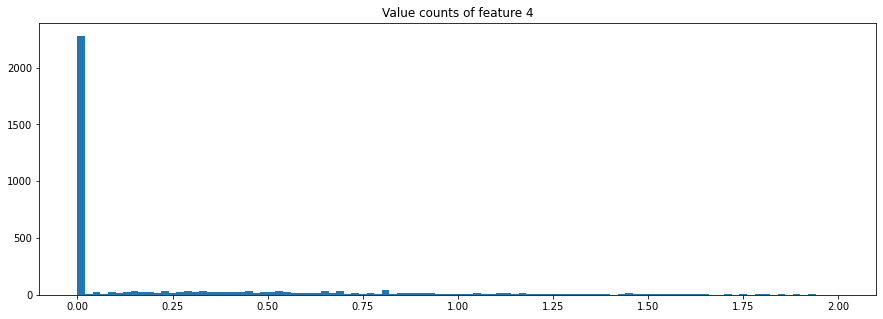

In [6]:
# Histogram giving value counts of feature 4
fig, ax = plt.subplots(figsize = (15, 5))

ax.hist(trainval[4], bins  = 100, range = (0, 2))

ax.set_title('Value counts of feature 4');

#### Correlation

The correlation between a feature and the output gives the proportion of the variance of the outcome that is predictable from the feature. This gives us a ranking of the predictive power of the different features. The square correlation is also known at the *coefficient of determination* or $r^2$.

**TO DO: Analysis of $R^2$** 

It is also useful to look at correlation between features to understand redundancy.

In [7]:
# Correlation matrix
corr = trainval.corr(method = 'pearson')
abs_corr = np.abs(corr)

# Examine the highest correlations between features
max_corr = abs_corr[abs_corr != 1].stack().nlargest(15)
max_corr_feat = sorted(list({pair[0] for pair in max_corr.index}))
print('Features with the greatest correlations:')
corr.loc[max_corr_feat, max_corr_feat]

Features with the greatest correlations:


,30,31,33,35,39
30,1.000000,0.744586,0.741407,0.646897,0.695687
31,0.744586,1.000000,0.995060,0.757557,0.874787
33,0.741407,0.995060,1.000000,0.754172,0.871114
35,0.646897,0.757557,0.754172,1.000000,0.690927
39,0.695687,0.874787,0.871114,0.690927,1.000000


This collection of features is highly correlated. This redundancy is undesirable and may increase the variance of models meaning that they generalise poorly. We will look later at ways to ameliorate this.

Finally we look the rank of the data matrix to ensure that the columns are linearly independent.

In [8]:
# Compare matrix rank with number of columns
rank = np.linalg.matrix_rank(trainval)
if rank == trainval.shape[1]:
    print('The data matrix has full column rank')
else:
    print('The data matrix has linearly dependent columns')

The data matrix has full column rank


### Data Preparation

We split the data into inputs $X$ and outputs $y$, cast to Numpy arrays, and store some useful values.

In [9]:
# Split into inputs and outputs
X_train = train.loc[:, :56].to_numpy()
y_train = train.loc[:, 57].to_numpy()
N_train = len(y_train)

X_val = val.loc[:, :56].to_numpy()
y_val = val.loc[:, 57].to_numpy()
N_val = len(y_val)

X_test = test.loc[:, :56].to_numpy()
y_test = test.loc[:, 57].to_numpy()
N_test = len(y_test)

# Combined training/validation data
X_trainval = trainval.loc[:, :56].to_numpy()
y_trainval = trainval.loc[:, 57].to_numpy()
N_trainval = len(y_trainval)

# Predefined split to aid validation with sklearn
test_fold = [-1] * N_train + [0] * N_val
ps = PredefinedSplit(test_fold)

# Number of features
num_feat = X_train.shape[1]

### Base Error Rate

Finally we calculate the base error rate; the mean-squared error when using the sample mean of $\mathbf{y}$ for all predictions (this is equivalent to linear regression with only the bias feature).

In [10]:
# Finding training sample mean
y_trainval_mean = y_trainval.mean()
print('Sample mean of train/val data: {:.3f}\n'.format(y_trainval_mean))

# Calculate base error for training data
y_trainval_pred_base = np.array([y_trainval_mean] * N_trainval)
base_trainval_err = (y_trainval - y_trainval_pred_base).T @ (y_trainval - y_trainval_pred_base) / N_trainval
print('Base error rate: {:.4f}'.format(base_trainval_err))

Sample mean of train/val data: 0.394

Base error rate: 0.2388


This is approximately what we would expect. In a binary classification problem with equal numbers of positive and negative observations, predicting 0.5 at all times will yield a mean-squared error of $(0.5)^2 = 0.25$. 

## Ordinary Least Squares

We begin by fitting a linear model to the data using least-squares. This is the simplest non-trivial way to fit a linear model to our data and will serve as a baseline on which we wish to improve.

Finding the least-squares fit will also allow us to make some additional inferences about the data. In particular we will:
- estimate the population variance;
- estimate the standard error of the least-squares approximation $\hat{\beta}$ to $\beta$;
- calculate the $Z$-scores under the null hypothesis that a specific coefficient $\beta_j$ is zero;
- conduct a hypothesis test against the null hypothesis that a batch of coefficients are simultaneously zero.

The last two bullets will give use a measure of the significance of the different features.


### Model Training

We fit the model using the training data. Although least-squares doesn't require validation, we still respect the split between training and validation to allow comparison with later models.

In [11]:
# Create linear regresssion object
ls = LinearRegression()

# Train using the data
ls.fit(X_train, y_train)

# Generate predictions for the training/validation data
y_train_pred_ls = ls.predict(X_train)

# Calculate an unbiased estimate of the variance in the data assuming a linear relationship
ls_train_rss = (y_train - y_train_pred_ls).T @ (y_train - y_train_pred_ls)
var_est = ls_train_rss / (N_train - num_feat - 1)
print('Unbiased estimate for population variance: {:.3f}'.format(var_est))

Unbiased estimate for population variance: 0.103


We evaluate the performance of the model using the mean-squared error. Calculating the error on the validation data gives us an insight into how the model with generalise to new data.

In [12]:
# Training error
ls_train_err = ls_train_rss / N_train
print('Least squares training error: {:.4f}'.format(ls_train_err))

# Validation error
y_val_pred_ls = ls.predict(X_val)
ls_val_err = (y_val - y_val_pred_ls).T @ (y_val - y_val_pred_ls) / N_val
print('Least squares validation error: {:.4f}'.format(ls_val_err))

Least squares training error: 0.1011
Least squares validation error: 0.1170


We have decreased the error from a base rate of 0.24 to around 0.1. Recall that the least squares fit minimises the training error among all linear models. All adjustments we make to our model from here on aim to decrease the generalisation error, estimated here by the validation error.

### Hypothesis Testing

We have obtained a least-squares approximation $\hat{\beta}^{\text{ls}}_j$ for each coefficient $\beta_j$. In this section we use these to conduct hypothesis tests again the null that a coefficient $\beta_j$ or group of coefficients are zero.

#### Z-Tests

We calculate the $Z$-scores for each coefficient $\beta_j$ under the null hypothesis that $\beta_j = 0$. In doing so we estimate the standard error of each $\hat{\beta}^{\text{ls}}_j$ as an estimator of $\beta_j$. An explanation of the formulas used can by found in [HPS, $\S$3.2.1].

In [13]:
# Estimate the variance of the least squares estimate
bias = np.ones(shape=(N_train, 1))
X_train_bias = np.concatenate((bias, X_train), axis=1)
coef_var_est = var_est * np.linalg.inv(X_train_bias.T @ X_train_bias)

# Create data frame to contain data
feat = list(range(57))
ls_coefs = pd.DataFrame(index = ['intercept'] + feat,
                        columns = ['coef', 'std_err', 'z_score', 'abs_z_score'],
                        dtype = 'float')
ls_coefs.index.name = 'feature'

# Fill in coefficient values
ls_coefs.loc[feat, 'coef'] = ls.coef_
ls_coefs.loc['intercept', 'coef'] = ls.intercept_

# Fill in standardnerrors
ls_coefs.loc[:, 'std_err'] = np.sqrt(np.diagonal(coef_var_est))

# Z-score is the coefficient over the estimated standard error
ls_coefs.loc[:, 'z_score'] = ls_coefs.coef / ls_coefs.std_err
ls_coefs.loc[:, 'abs_z_score'] = np.abs(ls_coefs.z_score)

# Print a summary of coefficient data ordered by absolute Z-score
ls_coefs.sort_values('abs_z_score', ascending = False).round(3)

,coef,std_err,z_score,abs_z_score
feature,,,,
6,0.206,0.015,13.663,13.663
intercept,0.193,0.015,13.013,13.013
15,0.093,0.008,10.957,10.957
4,0.092,0.010,9.609,9.609
51,0.093,0.010,9.219,9.219
20,0.054,0.006,9.154,9.154
52,0.276,0.030,9.103,9.103
22,0.174,0.022,8.083,8.083
56,0.000,0.000,6.978,6.978


Roughly speaking, an absolute $Z$-score above 2 signifies that the coefficient is significantly non-zero at the 95% level. Around 36 out of 58 terms are significantly non-zero at this level.

The absolute $Z$-scores give an indication of the relevance significance of different features, however this measure of importance can be misleading as it describes the effect of dropping a feature *while keeping the others in the model*. As an example, consider features 31 and 33. Both are near the bottom of the list of $Z$-scores. However, recall that these two are very highly correlated, so one while one would expect that dropping just one of them would have little effect on the model, dropping them both may have a large effect. 

#### F-Test

Motivated by the final paragraph of the previous section we perform an $F$-test against the null hypothesis that a group of coefficients are zero. The features we choose are $[30, 31, 33, 35, 39]$. Note that none of these are significantly individually non-zero, but since they are highly correlated it is worthwhile test if they are significantly non-zero when taken together. Again an explanation of the test we use can be found in [HPS, $\S$3.2.1].

In [14]:
# Take reduced set of features
test_feat = [30, 31, 33, 35, 39]

feat_red = feat.copy()
for item in test_feat:
    feat_red.remove(item)
    
# Fit least squares to reduced features
ls_red = LinearRegression()
ls_red.fit(X_train[:, feat_red], y_train)

# Calculate RSS for reduced model
y_train_pred_ls_red = ls_red.predict(X_train[:, feat_red])
ls_red_train_rss = (y_train - y_train_pred_ls_red).T @ (y_train - y_train_pred_ls_red)

# Calculate F-statistic
F_stat = (ls_red_train_rss - ls_train_rss) / (num_feat - len(feat_red))
F_stat /= var_est
print('F-statistic: {:.3f}'.format(F_stat))

# Percentiles of F-distribution
alpha = 0.05
df1 = num_feat - len(feat_red)
df2 = N_train - num_feat - 1
F_perc = stats.f(dfn=df1, dfd=df2).ppf(1-alpha)
print('{perc:.1f}th percentile of F-distribution with ({df1}, {df2}) degrees of freedom: {F_perc:.3f}'.format(perc=100*(1-alpha), df1=df1, df2=df2, F_perc=F_perc))

F-statistic: 3.295
95.0th percentile of F-distribution with (5, 2702) degrees of freedom: 2.217


So we reject the hypothesis that all five of these coefficients are zero at the 95% signficane level, although we *didn't* reject the hypothesis than any one of them is zero individually.

### Dependence on Training Set Size

Before moving on to other methods we investigate how the training and validation error vary depending on the size of the training sample. This will allow us to evaluate whether a larger training set would be beneficial. 

In [15]:
# Set training sample sizes to test
sample_size = np.array(list(range(300, N_train, 100)) + [N_train])

# Create arrays to hold errors
ls_train_err = np.empty(shape=(0, ))
ls_val_err = np.empty(shape=(0, ))

for size in sample_size:    
    # Train model
    ls_path = LinearRegression()
    ls_path.fit(X_train[:size, :], y_train[:size])
    
    # Add training errors
    y_train_pred_ls = ls_path.predict(X_train[:size, :])
    ls_train_err = np.append(ls_train_err, mean_squared_error(y_train[:size], y_train_pred_ls))
                                   
    # Add validation errors
    y_val_pred_ls = ls_path.predict(X_val[:size, :])
    ls_val_err = np.append(ls_val_err, mean_squared_error(y_val[:size], y_val_pred_ls))

We plot training and validation error against the size of the training set.

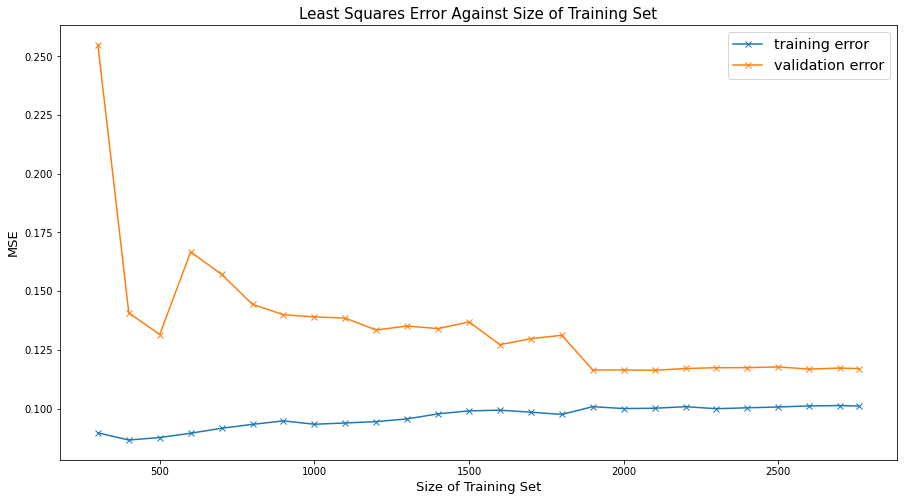

In [16]:
# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('Least Squares Error Against Size of Training Set', fontsize=15)
ax.set_xlabel('Size of Training Set', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)

# Plot errors
ax.plot(sample_size, ls_train_err, marker='x', label='training error')
ax.plot(sample_size, ls_val_err, marker='x', label='validation error')

ax.legend(fontsize='x-large');

Once our training set reaching size 2000 there is little change in training and validation error and in particular, little change in the difference between them. This suggests that our model will not be greatly improved if we find more training data; in order to improve our predicts we need to either add derived features or expand the class of models that we consider.

Note that this justifies our decision to split our data separate training and validation steps - having a larger training set would likely make little difference.

## Subset Selection

There are four methods for subset selection discussed in the text:
- best-subset selection
- forward-stepwise selection
- backward-stepwise selection
- forward-stagewise selection

Unfortunately none of these appear to be implemented in Scikit-learn. 

The closest to best-subset selection in scikit-learn is `feature_selection.SelectKBest`. For each index $j$, this conducts an $F$-test for the null hypothesis that $\beta_j=0$ under the assumption of a simple univariate model $Y=\beta_0 + \beta_j X_j$, and then chooses the $k$ indices with the highest $F$-scores. This is equivalent to choosing the indices with the highest coefficient of determination $R^2$. The issue with this is the same as described at the end of the previous section; it only considers the features individually. This can be problematic if some features are highly correlated as in our case.

There is also a method `feature_selection.RFE` (RFE stands for Recursive Feature Elimination) that sounds similar to backward-stepwise selection, but it requires the estimator to contain information about the feature importance which `LinearRegression` doesn't.

So we have to implement these methods ourselves. We will neglect best-subset and forward-stagewise - the first is only practical for up to 30-40 features and the second would take more time than I want to spend - and concrentrate on forward- and backward-stepwise sleection. With each method we will require:
- the full list of features in the order they are added/removed;
- the coefficients of the least squares fit at each step;
- the residual sum-of-squares at each step.

We will compare the outcome of the two methods on the spam data. In particular we wish to compare:
- the order in which features were added/removed;
- the speed of convergence to the training error of the full least-squares model;
- the evolution of training and validation errors with subset size.

We will then use validation to choose the complexity parameter - the subset size - for each method.

### Model Training

The following custom module allows us to apply forward- and backward-stepwise selection, compare their sequences of features, and compute their errors when run on a test set.

In [17]:
# Import stepwise-selection module
import stepsel

We begin by performing forward and backward stepwise selection on our training data.

In [18]:
# Forward stepwise
active_set, fss_coef, fss_RSS = stepsel.forward_stepwise_selection(X_train, y_train)

# Backward stepwise
inactive_set, bss_coef, bss_RSS = stepsel.backward_stepwise_selection(X_train, y_train)

### Comparing the Order of Features

From forward-stepwise selection we obtain a list `active_set` giving the order in which features were added to the model. From backward-stepwise selection we obtain a list `inactive_set` giving the order in which features were removed. Ideally we would hope that each of these lists were the reverse of the other, but this generally won't be the case. We would like a measure of how the orderings of these lists are different. The measure we will use is the number of *inversions*.

#### Inversions

The number of inversions between two permutations $\sigma_1$, $\sigma_2$ of a set $S$ is the number of pairs $a,b\in S$ such that $a$ comes before $b$ in $\sigma_1$ but after it in $\sigma_2$. For the moment (and without loss of generality) we will assume that $S = \{1,\ldots, n\}$, $\sigma_1$ has the elements of $S$ in order, and just speak of the number of inversions in $\sigma = \sigma_2$.

Let $I_n(k)$ denote the number of permutations of length $n$ with $k$ inversions. Then $I_n(k)$ is the coefficient of $x^k$ in

\begin{equation}
    \prod_{m=1}^n \sum_{i=0}^{m-1} x_i = (1+x)(1+x+x^2)\cdots(1+x+\cdots+x^{n-1}).
\end{equation}

In particular, $I_n(0) = 1$, $I_n\left(\frac{n(n-1)}{2}\right) = 1$, and $I_n(k)=0$ for $k > \frac{n(n-1)}{2}$. Moreover, $I_n(k)$ is symmetic: $I_n(k) = I_n\left(\frac{n(n-1)}{2} - k\right)$

Let $\xi_n$ be a random variable representing the number of inversions in a permutation in $S_n$ sampled with a uniform distribution. Then

\begin{equation}
    \text{E}(\xi_n) = \frac{n(n-1)}{4} \qquad\text{and}\qquad \text{Var}(\xi_n) = \frac{n(n-1)(2n+5)}{72}.
\end{equation}

Moreover, the standardised variable $(\xi_n - \text{E}(\xi_n)) \big/ \sqrt{\text{Var}(\xi_n)}$ has an asymptotically standard normal distribution.

See the 2001 paper 'Permutations with inversions' by Margolis in the Journal of Integer Sequences for more details: 

https://cs.uwaterloo.ca/journals/JIS/VOL4/MARGOLIUS/inversions.html

#### Comparison

We use inversions to compare the two sequences `active_set` and the reverse of `inactive_set`.

In [19]:
# Distribution of number of inversions
n_elts = len(active_set)
exp_inv = n_elts * (n_elts - 1) / 4
stdev_inv = sqrt(n_elts * (n_elts - 1) * (2 * n_elts + 5) / 72)
print('Expected number of inversions: {}'.format(exp_inv))
print('Standard deviation: {:.1f}\n'.format(stdev_inv))

# Count number of inversions between sequences of features
n_inv = stepsel.count_inversions(active_set, inactive_set[::-1])

print('Actual number of inversions: {}'.format(n_inv))
print('Proportion of pairs that are inverted: {:.3f}'.format(n_inv / (2 * exp_inv)))

Expected number of inversions: 826.5
Standard deviation: 74.5

Actual number of inversions: 127
Proportion of pairs that are inverted: 0.077


So the sequences are not identical. Around 8% of pairs of features are inverted. To put this in context we use the normal approximation to the number of inversions to get an approximate percentile.

In [20]:
# Find approximate percentile for number of inversions
norm = stats.norm(loc=exp_inv, scale=stdev_inv)
perc = norm.cdf(n_inv) * 100
print('Percentile of number of inversions: {}'.format(perc))

Percentile of number of inversions: 3.16161344665385e-19


So although the two sequences are different, statistically speaking they are extraordinarily similar. More precisely, there is essentially a 0% chance that two orderings of the features taken at random would be this similar.

### Evaluating Performance

We evaluate performance through training and validation error. We use mean-squared error as our error metric.

In [21]:
# Training errors
fss_train_err = fss_RSS / N_train
bss_train_err = bss_RSS / N_train

# Validation errors
fss_val_err = stepsel.test_error(fss_coef, X_val, y_val)
bss_val_err = stepsel.test_error(bss_coef, X_val, y_val)

The evaluation of training error allows us to compare how quickly the two models converge to the optimal solution

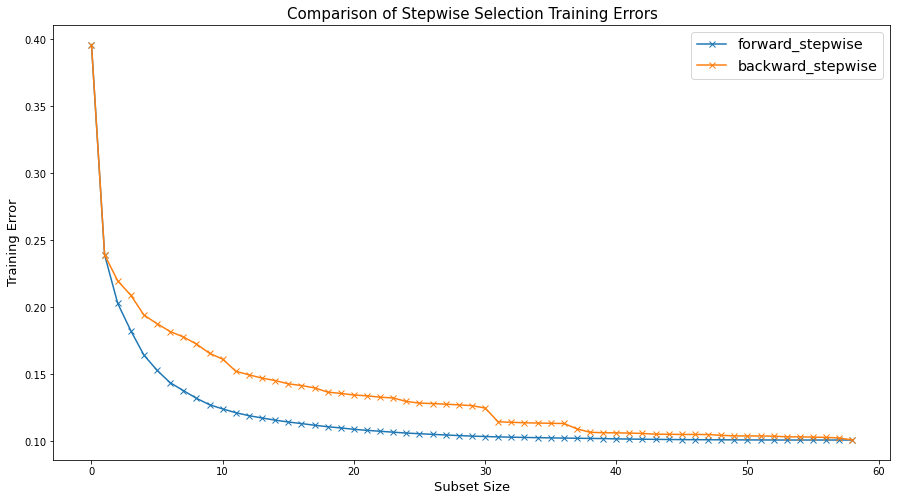

In [22]:
# Plot training error against subset size for both models
fig, ax = plt.subplots(figsize = (15, 8))

# Figure parameters
ax.set_title('Comparison of Stepwise Selection Training Errors', fontsize = 15)
ax.set_ylabel('Training Error', fontsize = 13)
ax.set_xlabel('Subset Size', fontsize = 13)

# Plot data
ax.plot(fss_train_err, marker = 'x', label = 'forward_stepwise')
ax.plot(bss_train_err, marker = 'x', label = 'backward_stepwise')

ax.legend(fontsize = 'x-large');

Observe that forward-stepwise selection converges to the error of the least-squares solution much more quickly than backward-stepwise. Moreover, the convergence of forward-stepwise is much smoother.

We want also wish to compare training and validation errors for the two models as subset size varies. This allows us to diagnose the bias-variance trade-off, estimate how our models will generalise to independent data, and choose the optimal subset size.

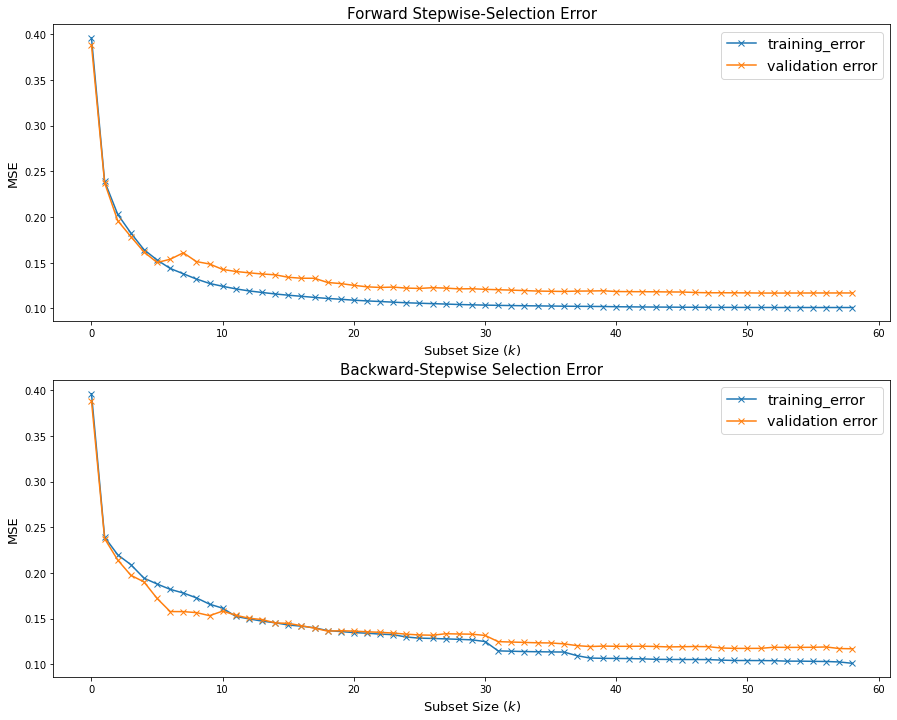

In [23]:
# Create two set of axes - one for each method
fig, [ax1, ax2] = plt.subplots(nrows = 2, figsize = (15, 12))

# Parameters for forward-stepwise axes
ax1.set_title('Forward Stepwise-Selection Error', fontsize = 15)
ax1.set_ylabel('MSE', fontsize = 13)
ax1.set_xlabel('Subset Size ($k$)', fontsize = 13)

# Plot forward-stepwise data
ax1.plot(fss_train_err, marker = 'x', label = 'training_error')
ax1.plot(fss_val_err, marker = 'x', label  = 'validation error')

ax1.legend(fontsize = 'x-large')

# Parameters for back-stepwise axes
ax2.set_title('Backward-Stepwise Selection Error', fontsize = 15)
ax2.set_ylabel('MSE', fontsize = 13)
ax2.set_xlabel('Subset Size ($k$)', fontsize = 13)

# Plot backward-stepwise data
ax2.plot(bss_train_err, marker = 'x', label = 'training_error')
ax2.plot(bss_val_err, marker = 'x', label  = 'validation error')

ax2.legend(fontsize = 'x-large');

As with the training error, the validation error for forward-stepwise selection converges much more quickly than backward and more smoothly. Both plateau around 0.117, compared with a training error of 0.101. The lowest validation error occurs for forward-stepwise at subset size $k=52$ and for backward-stepwise at $k=58$. However, the difference between the validation error for forward-stepwise at $k=52$ and $k=58$ is negligible and easily explained by random error.

This suggests that our models do not suffer from having too many parameters. If they did, we would expect the validation error to creep up as the subset size increased. Rather, the fact that both validation and training error plateau suggests that our models lack complexity and performance could be improved by either adding new features or changing the base model. This is unsurprising given that we are employing linear regression models with untransformed features, particularly given that this is really a classification task.

However, for the sake of the exercise we will select the forward-stepwise model with subset size $k=52$ moving forward.

In [24]:
# Restrict active set to the first 52 variables
# Need to reindex for data set without bias column
fss_active_set = [feat - 1 for feat in active_set[:52] if feat > 0]

# Create linear regresssion object
fss = LinearRegression()

# Train using the restricted features
fss.fit(X_train[:, fss_active_set], y_train)

# Calculate training error
y_train_pred_fss = fss.predict(X_train[:, fss_active_set])
y_train_pred_err = (y_train - y_train_pred_fss).T @ (y_train - y_train_pred_fss) / N_train
print('Foward-stepwise regression training error: {:.4f}'.format(y_train_pred_err))

# Calculate validation error
y_val_pred_fss = fss.predict(X_val[:, fss_active_set])
y_val_pred_err = (y_val - y_val_pred_fss).T @ (y_val - y_val_pred_fss) / N_val
print('Foward-stepwise regression validation error: {:.4f}'.format(y_val_pred_err))

Foward-stepwise regression training error: 0.1011
Foward-stepwise regression validation error: 0.1169


## Derived Input Directions

Our two derived input methods - Principal Component Regression (PCR) and Partial Least Squares (PLS) - work by applying a carefully chosen change of base for the input data before taking the best subset. The idea is to replace features with linear combinations such that the predictive power of the data is contained in as few features as possible. This should make restricting to a subset more effective.

### Principal Component Regression

Principal Component Regression (PCR) works by regressing on the directions that best explain the variance in the input data.

#### Principal Component Analysis

We begin by computing the principal components of the input data. The first principal component direction is the direction that most explains the variance in `X_train`. The second direction explains the most variance under the constraint that it is orthogonal to the first principal component direction.

In [25]:
# Fit PCA to training inputs
pca = make_pipeline(StandardScaler(), PCA())
pca.fit(X_train);

The following figure shows the proportion of the variance of `X_train` that is explained by each of the principal components. Equivalently, it shows the eigenvalues of the covariance matrix $X_{\text{train}}^TX_{\text{train}} / N_{\text{train}}$, scaled so that they sum to one.

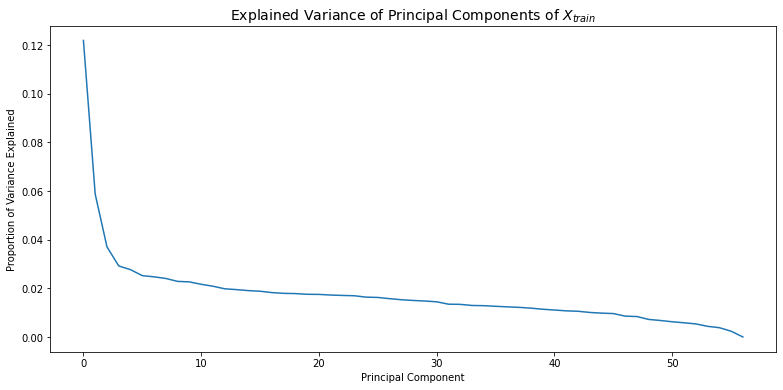

In [26]:
# Generate axes
fig, ax  = plt.subplots(figsize=(13, 6))

# Plot parameters
ax.set_title('Explained Variance of Principal Components of $X_{train}$', fontsize=14)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')

ax.plot(pca['pca'].explained_variance_ratio_);

So the first few principal components explain a large amount of the variance, but later components explain little.

We expect a regressing on a subset of principal components to be more effective than regression on a subset of original features. This is based on the implicit assumption that the $y$ with tend to vary most in the directions of highest variance in the inputs. The validity of this assumption comes down to how well we have chosen our features.

To demonstrate the advantage of regression on principal components we compare a plot of $y$ against the first two features chosen by forward-stepwise selection and a plot of $y$ against the first two principal components.

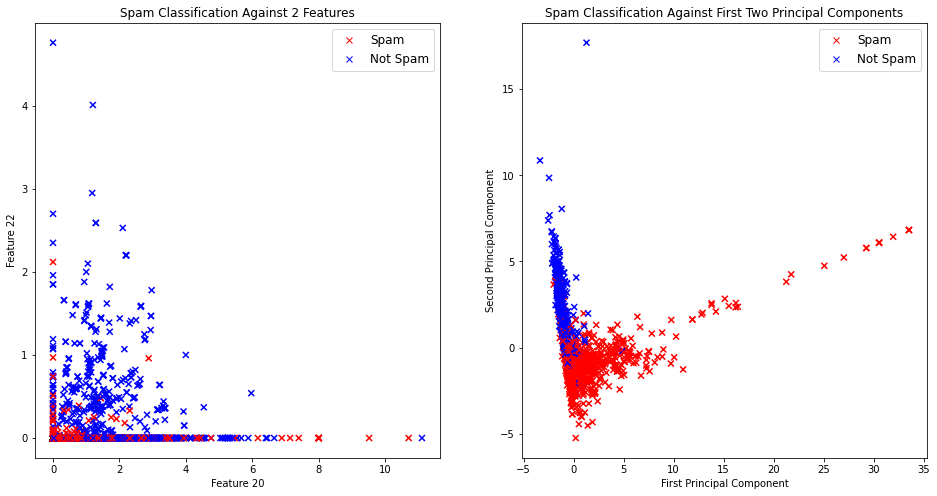

In [27]:
# Initialise figure
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(16, 8))

# Axis 1 parameters
ax1.set_title('Spam Classification Against 2 Features')
ax1.set_xlabel('Feature 20')
ax1.set_ylabel('Feature 22')

# Plot y against first two features of X
ax1.scatter(X_train[:, 20], X_train[:, 22], c=y_train, cmap=ListedColormap(["red", "blue"]), marker='x')

# Axis 2 parameters
ax2.set_title('Spam Classification Against First Two Principal Components')
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')

# Plot y against first two principal components of X
X_train_pc = pca.transform(X_train)
ax2.scatter(X_train_pc[:, 0], X_train_pc[:, 1], c=y_train, cmap=ListedColormap(["red", "blue"]), marker='x')

# Legend
legend_elements = [Line2D([0], [0], color='red', linewidth=3, marker='x', linestyle='', label='Spam'),
                   Line2D([0], [0], color='blue', linewidth=3, marker='x', linestyle='', label='Not Spam')]
ax1.legend(handles=legend_elements, fontsize='large')
ax2.legend(handles=legend_elements, fontsize='large');

Although features 20 and 22 are the best two features for this problem, the principal components do a much better job at separating the spam and non-spam e-mails.

#### Principal Components Regression

We perform a least-squares fit against the first $k$ principal components. We will use validation to choose the optimal value for $k$.

In [28]:
# Parameter grid for grid search
pcr_params = range(1, num_feat + 1)
param_grid = {'pca__n_components' : pcr_params}

# Create pipeline
pcr_pipe = make_pipeline(StandardScaler(), PCA(), LinearRegression())

# Create grid search
scoring = 'neg_mean_squared_error'
pcr = GridSearchCV(pcr_pipe, 
                     param_grid, 
                     scoring=scoring,
                     cv = ps,
                     return_train_score=True)

# Fit to data
pcr.fit(X_trainval, y_trainval)

# Get training and valuation error (negative scores because our scoring function was negative mse)
pcr_train_err = -pcr.cv_results_['split0_train_score']
pcr_val_err = -pcr.cv_results_['split0_test_score']

# Optimal values
pcr_param_best = pcr.best_params_['pca__n_components']
pcr_val_err_best = -pcr.best_score_
print('PCR minimum validation error: {:.4f}'.format(pcr_val_err_best))
print('Optimal number of principal components: {:}'.format(pcr_param_best))

PCR minimum validation error: 0.1165
Optimal number of principal components: 35


We plot training and validation errors against model complexity

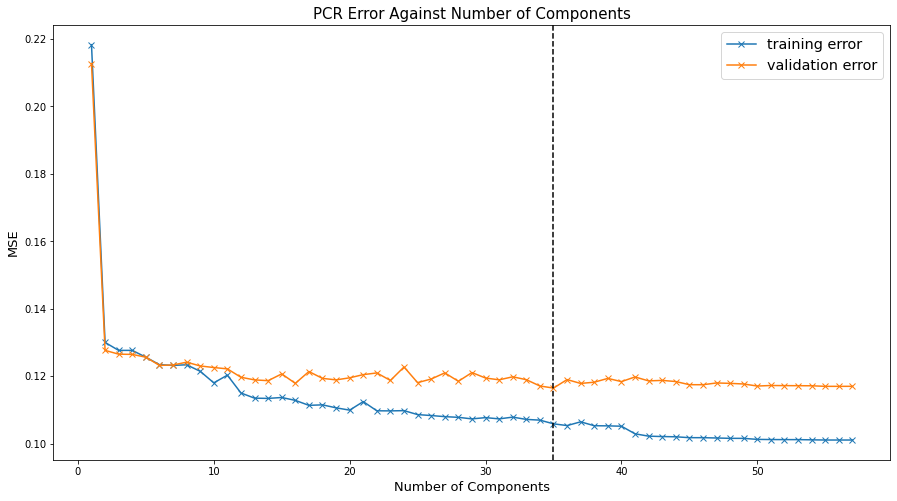

In [29]:
# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('PCR Error Against Number of Components', fontsize=15)
ax.set_xlabel('Number of Components', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)

# Plot errors
ax.plot(pcr_params, pcr_train_err, marker='x', label='training error')
ax.plot(pcr_params, pcr_val_err, marker='x', label='validation error')

# Plot optimal value
ax.axvline(pcr_param_best, linestyle='--', color='k')

ax.legend(fontsize='x-large');

Observe that error initially decreases very quickly as we specifically designed the first few components to contain the majority of the variance in $X$. Moreover, the optimal number of components - 34 - is far lower than that found by subset selection on its own and it leads to a lower validation error.

### Partial Least Squares

An issue with PCR is that doesn't take the output $y$ into account when selection the optimal directions. Intuitively,  the directions that best capture the relationship between $X$ and $y$ should take both into account. Partial Least Squares (PLS) selects directions that explain the variance in $X$ well, but also have high correlation with $y$.

#### Analysis

We begin by finding the PLS directions.

In [30]:
# Fit PLS to training inputs
pls = make_pipeline(StandardScaler(), PLSRegression(n_components=num_feat, scale=False))
pls.fit(X_train, y_train);

To see how this transforms the data we plot the distribution of spam and non-spam e-mails against the first six PLS directions.

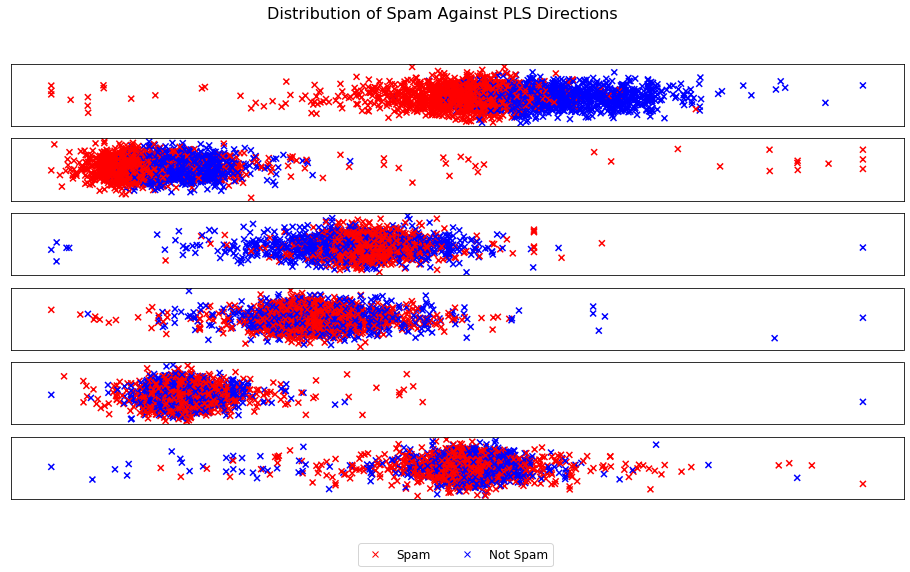

In [31]:
# Initialise figure
fig, axs = plt.subplots(nrows=6, figsize=(16, 8))

# Fig parameters
#axs[0].set_title('Distribution of Spam Against PLS Directions', fontsize=14)
fig.suptitle('Distribution of Spam Against PLS Directions', fontsize=16)

# Plot y against first two principal components of X
X_train_pls = pls.transform(X_train)

for idx, ax in enumerate(axs):
    ax.scatter(X_train_pls[:, idx], np.random.normal(size=N_train), c=y_train, cmap=ListedColormap(["red", "blue"]), marker='x')
    ax.set_yticks([])
    ax.set_xticks([])

# Legend
legend_elements = [Line2D([0], [0], color='red', linewidth=3, marker='x', linestyle='', label='Spam'),
                   Line2D([0], [0], color='blue', linewidth=3, marker='x', linestyle='', label='Not Spam')]
fig.legend(handles=legend_elements, fontsize='large', ncol=2, loc=8);

Each of the $x$-axes here corresponds to one PLS direction. The $y$-axis is simulated 'jitter' to make it easier to read.

Observe the extent to which this has concentrated the relevant information in $X$. The first two PLS directions in particular are extremely good at separating spam from non-spam, but by the fourth direction it is difficult to see any pattern.

#### Parameter Selection

We perform a least-squares fit on the first $k$ PLS components. We will select the optimal value of $k$ using validation.

In [32]:
# Parameter grid for grid search
pls_params = range(1, num_feat + 1)
param_grid = {'plsregression__n_components' : pls_params}

# Create pipeline
pls_pipe = make_pipeline(StandardScaler(), PLSRegression(scale=False))

# Create grid search
scoring = 'neg_mean_squared_error'
pls = GridSearchCV(pls_pipe, 
                     param_grid, 
                     scoring=scoring,
                     cv = ps,
                     return_train_score=True)

# Fit to data
pls.fit(X_trainval, y_trainval)

# Get training and valuation error (negative scores because our scoring function was negative mse)
pls_train_err = -pls.cv_results_['split0_train_score']
pls_val_err = -pls.cv_results_['split0_test_score']

# Optimal values
pls_param_best = pls.best_params_['plsregression__n_components']
pls_val_err_best = -pls.best_score_
print('PLS minimum validation error: {:.4f}'.format(pls_val_err_best))
print('Number of components: {:}'.format(pls_param_best))

PLS minimum validation error: 0.1165
Number of components: 3


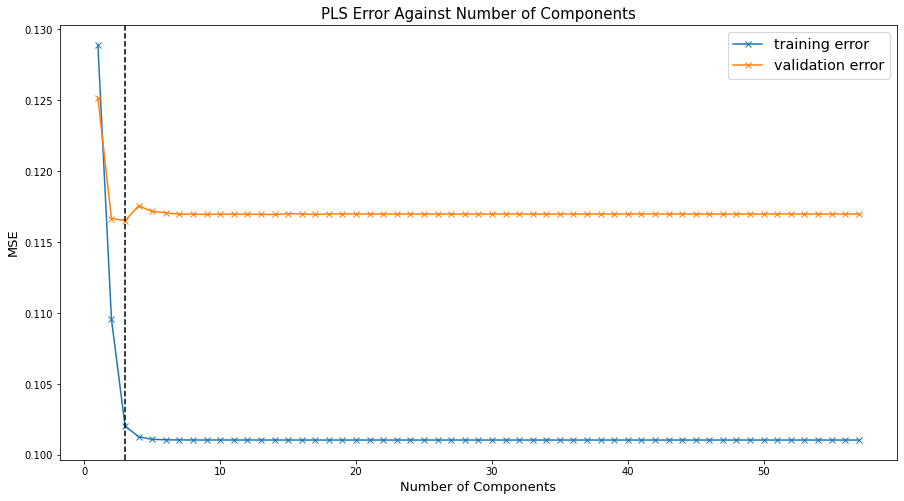

In [33]:
# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('PLS Error Against Number of Components', fontsize=15)
ax.set_xlabel('Number of Components', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)

# Plot errors
ax.plot(pls_params, pls_train_err, marker='x', label='training error')
ax.plot(pls_params, pls_val_err, marker='x', label='validation error')

# Plot optimal value
ax.axvline(pls_param_best, linestyle='--', color='k')

ax.legend(fontsize='x-large');

The behaviour we saw with PCR is even more acute. It appears that all the relevant data for the least-squares fit of $X$ to $y$ is contained in just the first five PLS directions and a model with just three transformed features will be yield improvement.

## Ridge Regression

This is the first of our shrinkage methods. The principle behind these methods is to to artificially shrink the coefficients in the linear model to decrease variance and hence generalisation error. In contrast to the methods seen so far the shrinkage methods are continuous, depending on a real-valued complexity parameter $\alpha>0$ which controls the shrinkage.

Ridge regression is closely related to Principal Components Regression. In the basis defined by the principal components, ridge regression shrinks the coefficient of each component according to the amount of variance it explains so that the first components are shrunk less. This makes ridge something like a continuous analogue of PCR.

#### Parameter Selection

We perform a grid search over values of the complexity parameter $\alpha$ to find the value that minimises validation error.

In [34]:
# Parameter grid for grid search
#ridge_params = np.linspace(0, 4000, 100)
ridge_params = np.linspace(0, 200000, 500)
param_grid = {'ridge__alpha' : ridge_params}

# Instantiate model
ridge_pipe = make_pipeline(StandardScaler(), 
                           Ridge(fit_intercept=True, normalize=False, tol = 1e-4))

# Create grid search
scoring = 'neg_mean_squared_error'
ridge = GridSearchCV(ridge_pipe, 
                     param_grid, 
                     scoring=scoring,
                     cv = ps,
                     return_train_score=True)

# Fit to data
ridge.fit(X_trainval, y_trainval)

# Get training and valuation error (negative scores because our scoring function was negative mse)
ridge_train_err = -ridge.cv_results_['split0_train_score']
ridge_val_err = -ridge.cv_results_['split0_test_score']

# Optimal values
ridge_param_best = ridge.best_params_['ridge__alpha']
ridge_val_err_best = -ridge.best_score_
print('Ridge minimum validation error: {err:.4f} at alpha = {param:.0f}'.format(err=ridge_val_err_best, param=ridge_param_best))

Ridge minimum validation error: 0.1140 at alpha = 802


We want to plot how training and valuation error change with model complexity. However, the parameter $\alpha$ doesn't provide a meaningful scale. Instead we will plot the errors against *effective degrees of freedom* $\text{df}(\alpha)$ as defined in [HTF, $\S$3.4.2]. 

Roughly, we should think that $\text{df}(\alpha) = k$ corresponds to a least-squares fit with $k$ features. However, this doesn't allow a direct comparison with the subset selection methods since we considered *all* features when choosing which subset of size $k$ to select (this is particularly true of the derived direction methods). This means that a model with subset size $k$ has effective degrees of freedom greater than $k$ and thus the subset selection and derived input graphs should be stretched for small values of $k$ and compressed for higher values.

In [35]:
def df_ridge(alpha, sing_val):
    '''
    Computes effective degrees of freedom for a ridge model
    
    Parameters:
    ----------
    alpha: int, float, list, or array of shape (k, )
           Complexity parameter(s)
           
    sing_val: numpy array of shape (p, )
              Singular values of standardised input data matrix
    
    Returns:
    -------
    df: float or array of shape (k, )
        Effective degrees of freedom for each alpha
    '''
    if type(alpha) is not np.ndarray:
        alpha = np.array(alpha)
        
    cross_sums = sum(np.meshgrid(alpha, sing_val ** 2))
    df = (sing_val ** 2) @ (1 / cross_sums)
    
    return df

We use this function to calculate the degrees of freedom for the complexity parameters in our grid search.

In [36]:
# Standardise data
scaler = StandardScaler()
scaler.fit(X_train)

# Compute singular values of standardised data
sing_val = np.linalg.svd(scaler.transform(X_train), compute_uv=False)

# Compute degrees of freedom for parameters used in ridge model
ridge_params_df = df_ridge(ridge_params, sing_val)
ridge_param_best_df = df_ridge(ridge_param_best, sing_val)

Now we plot the training and validation error against effective degrees of freedom.

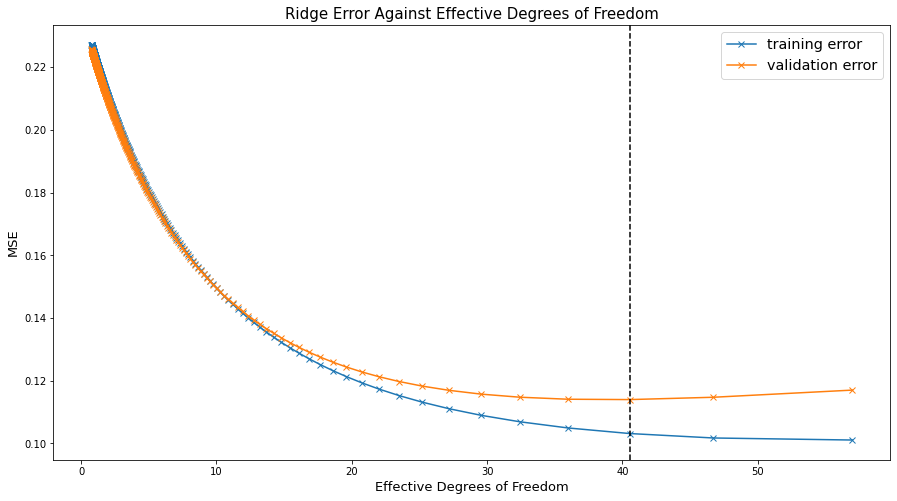

In [37]:
# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('Ridge Error Against Effective Degrees of Freedom', fontsize=15)
ax.set_xlabel('Effective Degrees of Freedom', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)

# Plot errors
ax.plot(ridge_params_df, ridge_train_err, marker='x', label='training error')
ax.plot(ridge_params_df, ridge_val_err, marker='x', label='validation error')

# Plot optimal value
ax.axvline(ridge_param_best_df, linestyle='--', color='k')

ax.legend(fontsize='x-large');

The graph shows how training and validation error change with the degrees of freedom. The least-squares fit corresponds to the right-most points and the vertical line gives the value of $\text{df}$ that minimises validation error.

The shape of the graph demonstrates that the full least squares fit has too high variance. While the training error continues to decrease with $\text{df}$, the validation error starts to increase which suggests that we are over-fitting the data. By using a ridge model with $\alpha=802$ we hope to decrease error on the test set.

#### Coefficient Paths

Before moving on we plot the evolution of coefficients against degrees of freedom to demonstrate how ridge applies shrinkage. First we calculate the coefficients for different values of $\alpha$.

In [38]:
# Choose alpha values to plot
coef_plot_params = np.linspace(0, 200000, 300)

# Initialise array for coefficients
coef = np.empty(shape=(num_feat, 0))

# Store coefficients in columns of coef for each value of alpha
for alpha in coef_plot_params:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha, tol=1e-4))
    pipe.fit(X_train, y_train)
    coef = np.concatenate([coef, pipe['ridge'].coef_[:, None]], axis = 1)
    
# Calculate degrees of freedom for alpha values
coef_plot_params_df = df_ridge(coef_plot_params, sing_val)

# Add df = 0 <-> alpha = inf
coef_plot_params_df = np.append(coef_plot_params_df, 0)
coef = np.concatenate([coef, np.zeros(shape=(num_feat, 1))], axis = 1)

Now we plot the coefficient paths for 10 randomly selected features.

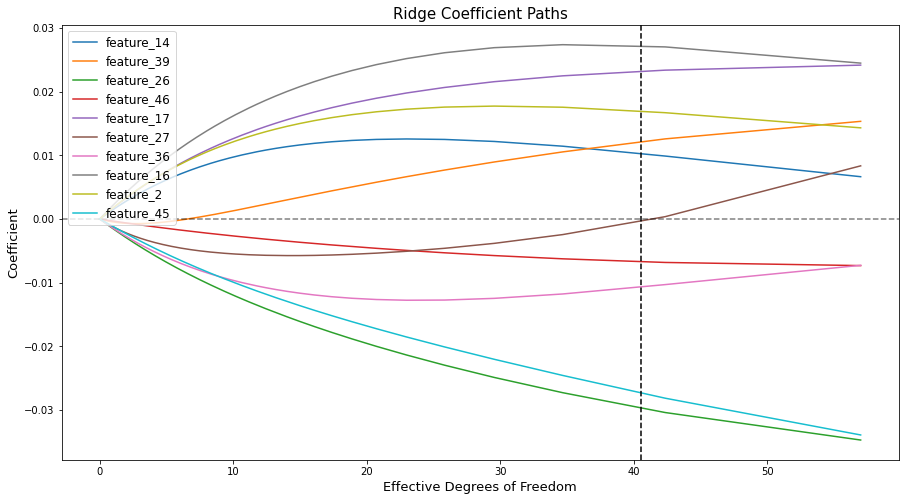

In [39]:
# Choose 10 features at random to plot
coef_plot_feat = np.random.choice(range(num_feat), size=10, replace=False)

# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('Ridge Coefficient Paths', fontsize=15)
ax.set_xlabel('Effective Degrees of Freedom', fontsize=13)
ax.set_ylabel('Coefficient', fontsize=13)

# Plot coefficient paths
for feat in coef_plot_feat:
    ax.plot(coef_plot_params_df, coef[feat, :], label='feature_{}'.format(str(feat)))

# Plot optimal value
ax.axvline(ridge_param_best_df, linestyle='--', color='k')

# Plot y = 0
ax.axhline(0, linestyle='--', color='k', alpha=0.5)

ax.legend(fontsize='large', loc=2);

Again, the right-most values are the least-squares fit and the vertical line is the optimal value chosen by validation. Note that the coefficients vary smoothly (but *not* linearly or monotonically) towards their final value.

## Lasso

Lasso is similar to ridge regression in that it shrinks coefficients to reduce variance and this shrinkage is controlled by a complexity parameter $\alpha$. However, while ridge regression results in smooth coefficient paths, lasso coefficient paths are piecewise linear and undergo soft-thresholding. This has the advantage that the final lasso model will depend on only a subset of the features.

We begin by calculating the full coefficient path under lasso using the modified LAR algorithm. We will use $L^1$ arc length for our horizontal scale in plots, scaled so that the least-squares fit is at 1.0.

Note: lasso and LAR are very similar so we don't consider is worthwhile to take a model for each through to the test stage. In fact, in this case the lasso and LAR algorithms are identical.

In [40]:
# Calculate lasso path
lasso_path = make_pipeline(StandardScaler(), 
                           LassoLars(alpha=0, fit_intercept=True, normalize=False, fit_path=True))
lasso_path.fit(X_train, y_train)
lasso_path_coef = lasso_path['lassolars'].coef_path_
lasso_path_params = lasso_path['lassolars'].alphas_

# Scaled arc lengths along path
lasso_arc_length = np.sum(np.abs(lasso_path_coef), axis=0)
lasso_scaled_arc_length = lasso_arc_length / lasso_arc_length[-1]

We plot the coefficient paths for 10 features selected at random.

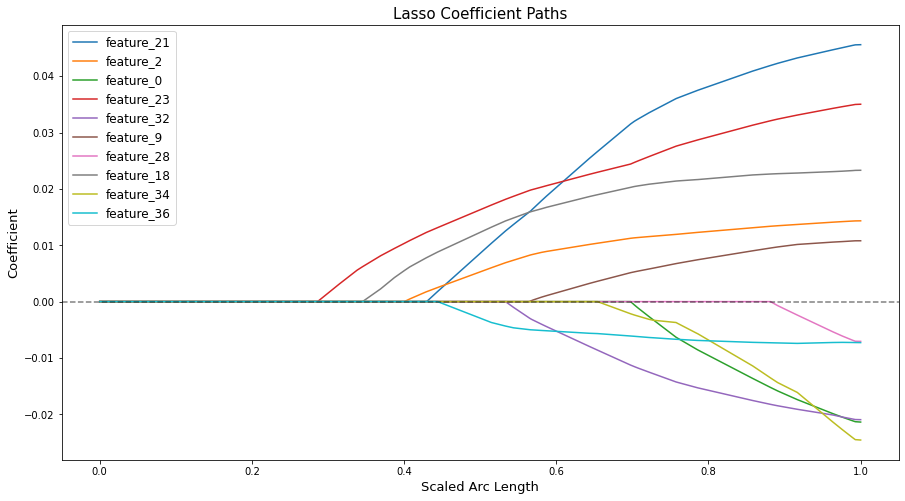

In [41]:
# Choose 10 features at random to plot
coef_plot_feat = np.random.choice(range(num_feat), size=10, replace=False)

# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('Lasso Coefficient Paths', fontsize=15)
ax.set_xlabel('Scaled Arc Length', fontsize=13)
ax.set_ylabel('Coefficient', fontsize=13)

# Plot coefficient paths
for feat in coef_plot_feat:
    ax.plot(lasso_scaled_arc_length, lasso_path_coef[feat, :], label='feature_{}'.format(str(feat)))

# Plot y = 0
ax.axhline(0, linestyle='--', color='k', alpha=0.5)

ax.legend(fontsize='large', loc=2);

As mentioned above, that the coefficient paths are piecewise linear and are zero for a portion of the path - soft-thresholding.

Now we use validation to find the complexity parameter $\alpha$ that minimises validation error. We use the $\alpha$ values from the coefficient path as the values to test.

In [42]:
# Parameter grid for grid search
param_grid = {'lassolars__alpha' : lasso_path_params}

# Instantiate model
lasso_pipe = make_pipeline(StandardScaler(), 
                           LassoLars(fit_intercept=True, normalize=False, fit_path=True))

# Create grid search
scoring = 'neg_mean_squared_error'
lasso = GridSearchCV(lasso_pipe, 
                     param_grid, 
                     scoring=scoring,
                     cv = ps,
                     return_train_score=True)

# Fit to data
lasso.fit(X_trainval, y_trainval)

# Get training and valuation error (negative scores because our scoring function was negative mse)
lasso_train_err = -lasso.cv_results_['split0_train_score']
lasso_val_err = -lasso.cv_results_['split0_test_score']

# Optimal values
lasso_param_best = lasso.best_params_['lassolars__alpha']
lasso_idx_best = lasso.best_index_
lasso_val_err_best = -lasso.best_score_
print('Lasso minimum validation error: {:.4f}'.format(lasso_val_err_best, param=lasso_param_best))
print('Corresponding alpha value: {:.5f}'.format(lasso_param_best))

# Calculate number of non-zero coefficients at each alpha value
lasso_df = np.count_nonzero(lasso_path_coef, axis=0)
lasso_df_best = lasso_df[lasso_idx_best]
print('Approximate effective degrees of freedom: {}'.format(lasso_df_best))

Lasso minimum validation error: 0.1162
Corresponding alpha value: 0.00412
Approximate effective degrees of freedom: 48


For lasso, the effective degrees of freedom is approximately equal to the number of non-zero coefficients, so the optimal lasso model only depends on 48 features rather than the full 57.

Now we plot training and validation errors against scaled $L^1$ arc length.

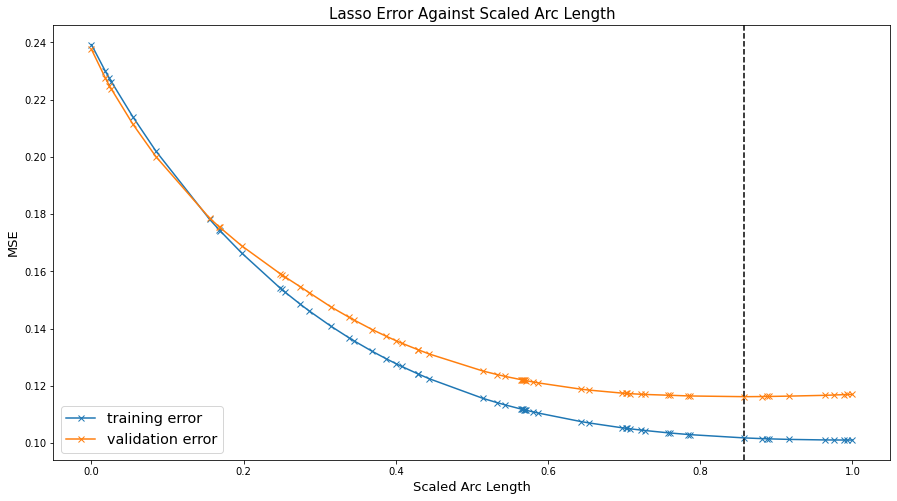

In [43]:
# Initialise plot
fig, ax = plt.subplots(figsize=(15, 8))

# Fig parameters
ax.set_title('Lasso Error Against Scaled Arc Length', fontsize=15)
ax.set_xlabel('Scaled Arc Length', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)

# Plot errors
ax.plot(lasso_scaled_arc_length, lasso_train_err, marker='x', label='training error')
ax.plot(lasso_scaled_arc_length, lasso_val_err, marker='x', label='validation error')

# Plot optimal value
ax.axvline(lasso_scaled_arc_length[lasso_idx_best], linestyle='--', color='k')

ax.legend(fontsize='x-large');

As usual, complexity increases as we move right so the far right point corresponds to the least-squares solution and the vertical line corresponds to the value that minimises validation error.

Note that as with forward-stepwise selection the training and validation errors have more-or-less stabilised by the time 48 features are included in the model and adding more makes little difference.

## Testing

We apply each of the models described to the test set using the parameters chosen through validation and calculate mean-squared error. To maximise performance, we use both the training and validation sets to fit our models.

In [53]:
# Ordinary least-squares
ls = LinearRegression()
ls.fit(X_trainval, y_trainval)
y_test_pred_ls = ls.predict(X_test)
ls_test_err = mean_squared_error(y_test, y_test_pred_ls)

model_err_df['least_squares'] = [ls_train_err[-1], ls_val_err[-1], ls_test_err]

# Forward-stepwise selection
fss = LinearRegression()
fss.fit(X_trainval[:, fss_active_set], y_trainval)
y_test_pred_fss = fss.predict(X_test[:, fss_active_set])
fss_test_err = mean_squared_error(y_test, y_test_pred_fss)

model_err_df['forward-stepwise'] = [fss_train_err, fss_val_err, fss_test_err]

# Principal components regression
y_test_pred_pcr = pcr.predict(X_test)
pcr_test_err = mean_squared_error(y_test, y_test_pred_pcr)

model_err_df['pcr'] = [pcr_train_err, fss_val_err, pcr_test_err]

# Partial least squares
y_test_pred_pls = pls.predict(X_test)
pls_test_err = mean_squared_error(y_test, y_test_pred_pls)

# Ridge regression
y_test_pred_ridge = ridge.predict(X_test)
ridge_test_err = mean_squared_error(y_test, y_test_pred_ridge)

# Lasso
y_test_pred_lasso = lasso.predict(X_test)
lasso_test_err = mean_squared_error(y_test, y_test_pred_lasso)

# Collect errors in dataframe
test_err_df = pd.DataFrame([{'model' : 'least_squares', 'test_err' : ls_test_err},
                        {'model' : 'forward-stepwise', 'test_err' : fss_test_err},
                        {'model' : 'pcr', 'test_err' : pcr_test_err},
                        {'model' : 'pls', 'test_err' : pls_test_err},
                        {'model' : 'ridge', 'test_err' : ridge_test_err},
                        {'model' : 'lasso', 'test_err' : lasso_test_err}])
test_err_df['test_err'] = test_err_df.test_err.round(4)
test_err_df = test_err_df.set_index('model')

# Display errors
test_err_df.T

model,least_squares,forward-stepwise,pcr,pls,ridge,lasso
test_err,0.116,0.1162,0.1197,0.1163,0.1141,0.1163
